# Setup and Configuration

## Connect to your google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Connect to Google Drive.
# All images required for the assignment were either provided by Dr. Vakanski or were publicly available
# Images were loaded onto google drive for ease of access

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install the adversarial robustness toolbox so that we can work with adversarial models
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.4 MB/s eta 0:00:00


## Import important libraries

In [4]:
# For inline matplot use
%matplotlib inline

# Import the following libraries

import os
import cv2
import sys
import keras
import random
import imageio
import tarfile
import natsort
import warnings
import numpy as np
import tensorflow as tf
import keras.backend as k
import matplotlib.pyplot as plt

In [5]:
# From installed and available libraries import these specific classes

from os import listdir

from keras.models import Model
from keras.applications import vgg16
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import NeuralCleanse

from skimage.util import compare_images
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from re import U

from mpl_toolkits import mplot3d

In [6]:
# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.enable_eager_execution()

# Supress warnings
warnings.filterwarnings('ignore')

In [7]:
# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
# print("Keras version:{}".format(keras.__version__))

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

TensorFlow version:2.18.0
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Helper Functions

## Plotting loss and accuracy

In [8]:
# Simple method used to print a models accuracy and loss.  Pass the method
# the history and both accuracy and loss will be displayed

def plot_accuracy_loss(the_history):
    # plot the accuracy and loss
    train_loss = the_history.history['loss']
    val_loss = the_history.history['val_loss']
    acc = the_history.history['accuracy']
    val_acc = the_history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

## Model Definitions

In [9]:
# For this assignment transfer learning was used for the base models.
# Specifically vgg16 models were used.  You may note that when using the
# models provided by Keras, their documentation mentions preprocessing
# the images.  This is intentionally left out as it caused issues with the
# accuracy of the predicitions.

# As the inputs and classes may change we pass those as variables to provide a
# more robust method for use.
def build_vgg16(input_shape, class_count):

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    # Add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a Dense layer with 2048 units
    x = Dense(2048, activation='relu')(x)

    # Add a Dropout layer with rate = 0.25
    x = Dropout(0.25)(x)

    # Add a Dense layer with 256 units
    x = Dense(256, activation='relu')(x)

    # Add a Dropout layer with rate = 0.25
    x = Dropout(0.25)(x)

    # Add a Dense output layer softmax activation
    predictions = Dense(class_count , activation='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

## Images Loader

In [10]:
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
        tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
        img_arr = np.array(tmp_img)
        imgs_list.append(img_arr/255.)

    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

## Global Variables

In [11]:
# Label Encoder for loading in data
le = LabelEncoder()

# Define a save path for use when training models(change the path)
save_path = 'Saves/'

# Define the path for weights to be stored
weight_path = 'Weights/'

# Define the path for the model to be stored
model_path = 'Models/'

# Define the extention for weights/models
ext = '.h5'

## Poisoning Attack

In [12]:
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
    else:
        raise("Unknown backdoor type")

def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = 1) -> np.ndarray:
    """
    Augments a matrix by setting a checkboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.
    :param x: N X W X H matrix or W X H matrix or N X W X H X C matrix, pixels will ne added to all channels
    :param distance: Distance from bottom-right walls.
    :param pixel_value: Value used to replace the entries of the image matrix.
    :return: Backdoored image.
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 4:
        width, height = x.shape[1:3]
        x[:, width - distance -1, height - distance -1, :] = pixel_value
        x[:, width - distance -1, height - distance - 3, :] = pixel_value
        x[:, width - distance -1, height - distance - 5, :] = pixel_value
        x[:, width - distance -1, height - distance - 7, :] = pixel_value
        x[:, width - distance - 3, height - distance -1, :] = pixel_value
        x[:, width - distance - 5, height - distance -1, :] = pixel_value
        x[:, width - distance - 7, height - distance -1, :] = pixel_value
        x[:, width - distance - 2, height - distance - 2, :] = pixel_value
        x[:, width - distance - 4, height - distance - 2, :] = pixel_value
        x[:, width - distance - 6, height - distance - 2, :] = pixel_value
        x[:, width - distance - 2, height - distance - 4, :] = pixel_value
        x[:, width - distance - 2, height - distance - 6, :] = pixel_value
        x[:, width - distance - 3, height - distance - 3, :] = pixel_value
        x[:, width - distance - 3, height - distance - 5, :] = pixel_value
        x[:, width - distance - 5, height - distance - 3, :] = pixel_value
        x[:, width - distance - 4, height - distance - 4, :] = pixel_value

    elif len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
        x[:, width - distance - 1, height - distance - 1] = pixel_value
        x[:, width - distance, height - distance - 2] = pixel_value
        x[:, width - distance - 2, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
        x[width - distance - 1, height - distance - 1] = pixel_value
        x[width - distance, height - distance - 2] = pixel_value
        x[width - distance - 2, height - distance] = pixel_value
    else:
        raise ValueError("Invalid array shape: " + str(shape))
    return x

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    # Sources: benign images, label 0
    # Targets: malignant images, label 1
    # We want to misclassify 20% of the benign images as malignant
    # The labels for sources and targets seems to be wrong
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

# Part 2: Backdoor Attack

- This  [notebook](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_training_mnist.ipynb) in the Adversarial Robustness Toolbox provides an example of applying the Backdoor Attack, as well as it explains the proposed defense strategy presented in the paper and referred to as Neural Cleanse.

- **Dataset: Breast Ultrasound Images (BUSI dataset)**
  - Consists of 780 images, categorized into normal, benign, and malignant classes.
  - These are gray images with 224x244 pixels size.

***Note***: The gray channel is replicated 3 times to result in images with 3 channels, since some models require that the input images have 3 channels.

## Step 1:

- Load the dataset and plot a figure with at least 9 images and the corresponding ground-truth labels.
- Train a deep learning model for classification of BUS images.
- Data Loaders files:
    - Training set: 60% of the data.
    - Validation set: 20% of the data.
    - Test set: 20% of the data.
- Plot the training curves.
- Expected that the classification accuracy on the test dataset is above 80%.


### Load Data

In [13]:
# TODO: Uncompress the dataset (change to your path )
!unzip -uq "/content/drive/MyDrive/AdversarialML/BUS_images.zip" -d "sample_data/"

In [14]:
# Load the images
all_images = load_images('sample_data/BUS_images')
print('Shape of the images:', all_images.shape)

# TODO: Load the labels (change to your path )
all_labels = np.loadtxt('/content/drive/MyDrive/AdversarialML/labels_BUSimages.csv', delimiter=',', dtype=str)
image_labels = le.fit_transform(all_labels)
print('Shape of the labels:', image_labels.shape)

Shape of the images: (780, 224, 224, 3)
Shape of the labels: (780,)


In [15]:
## TODO

# Split the data into 2 sets of data
# 1. A trainval set that will later be split into the training and validation sets
# 2. A test set which will be 20% of all data

# By setting the random state, we can ensure consistency when creating the datasets
# This allows us to focus on fine tuning our models

 # To Do : split to train_validation and test sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, image_labels, test_size=0.2, random_state=42)

# Using the trainval sets, we split the data again into our training and validation sets
# The validation set will be 20% of the remaining data and the remainder will be
# our training set

# To Do : split the train_validation set to two set train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    trainval_images, trainval_labels, test_size=0.2, random_state=42
)
# With all the necessary info loaded, we can free up space by deleting the imported images
del all_images

In [16]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# A list with the names of the image classes
label_names = np.unique(all_labels)

del all_labels

Images train shape: (499, 224, 224, 3) - Labels train shape: (499,)
Images validation shape: (125, 224, 224, 3) - Labels validation shape: (125,)
Images test shape: (156, 224, 224, 3) - Labels test shape: (156,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.3276967161593248
Data type float64


### Display images

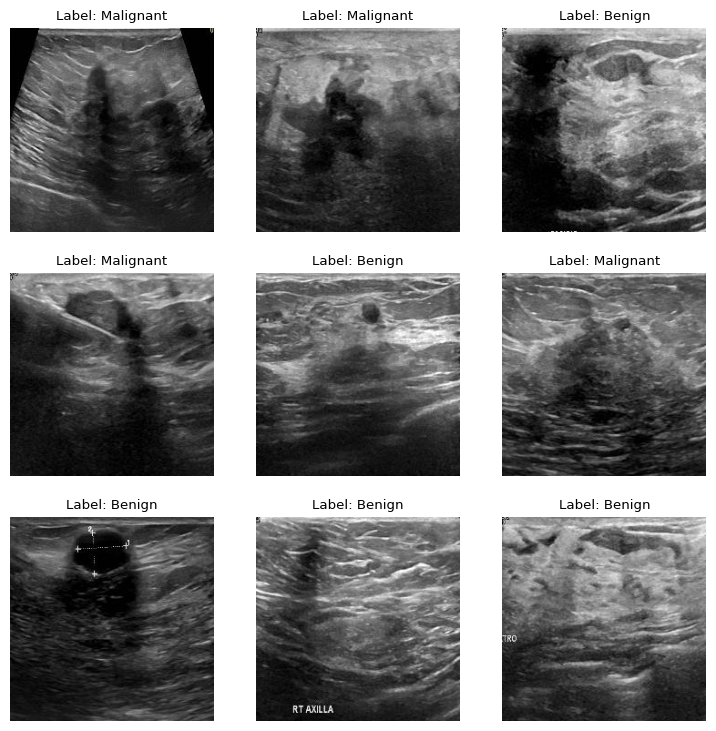

In [17]:
# Plot a few images to check if the labels make sense
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 8})
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

### Train a deep learning model above 80% accuracy

#### Paths and variables

In [19]:
weight_name = 'bd_weights_'
bd = 'bd/'

In [20]:
# input image shape
input_shape = (224, 224, 3)
NUM_CLASSES = len(label_names)

# change if you want

batch = 32
epochs = 5
iterations = 1



In [21]:
#choose the optimizer with proper learning rate
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=50,
    verbose=0,
    mode='auto'
)


In [22]:
train_labels_one_hot = np.eye(NUM_CLASSES)[train_labels]
val_labels_one_hot = np.eye(NUM_CLASSES)[val_labels]
test_labels_one_hot = np.eye(NUM_CLASSES)[test_labels]

#### Train the model

In [23]:
accuracy = []
histories = []

# Training loop
for i in range(iterations):

    # Build a model using the predefined function 'build_vgg16'
    model = build_vgg16(input_shape=input_shape, class_count=NUM_CLASSES)

    # Compile the model
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    print("Iteration: " + str(i+1) + " of " + str(iterations))
    path = save_path + weight_path + weight_name + str(i) + '.weights.h5'
    print("Weights will be saved here: " + path)

    model_checkpointer = ModelCheckpoint(
        path,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='auto'
    )

    # Fit the model with the training data, using validation data for evaluation
    history = model.fit(
        train_images, train_labels_one_hot,
        validation_data=(val_images, val_labels_one_hot),
        epochs=epochs,
        batch_size=batch,
        callbacks=[model_monitor, model_checkpointer],
        verbose=1
    )

    # Store the training history
    histories.append(history)

    # Evaluate the model on the test set
    loss_test, accuracy_test = model.evaluate(test_images, test_labels_one_hot)
    print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))
    accuracy.append(accuracy_test)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Iteration: 1 of 1
Weights will be saved here: Saves/Weights/bd_weights_0.weights.h5
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4686 - loss: 6.8702   
Epoch 1: val_loss improved from inf to 0.97826, saving model to Saves/Weights/bd_weights_0.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.4719 - loss: 6.6730 - val_accuracy: 0.5840 - val_loss: 0.9783
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4999 - loss: 1.0749
Epoch 2: val_loss did not improve from 0.97826
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 485ms/step - accuracy: 0.5013 - loss: 1.0734 - val_accuracy: 0.5840 - val_loss: 0.9840
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4616 - loss: 1.1184
Epoch 3: val_loss did not improve from 0.97826
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.4661 - loss: 1.1132 - val_accuracy: 0.5840 - val_loss: 0.9831
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 

#### Validate the best model and load it

In [24]:
## Print the index with the best accuracy
best = [index for index, item in enumerate(accuracy) if item ==max(accuracy)]
the_value = best[0]
print("The best index is: " + str(the_value))

The best index is: 0


In [31]:
best_model = build_vgg16(input_shape, NUM_CLASSES)
best_model.compile(
    loss="categorical_crossentropy",  # Fix: Use categorical_crossentropy
    optimizer=adam,
    metrics=['accuracy']
)


Expected best weights path: Saves/Weights/bd_weights_0.weights.h5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       1,050,6

 Total params: 48,871,883 (186.43 MB)

 Trainable params: 16,290,627 (62.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,581,256 (124.29 MB)

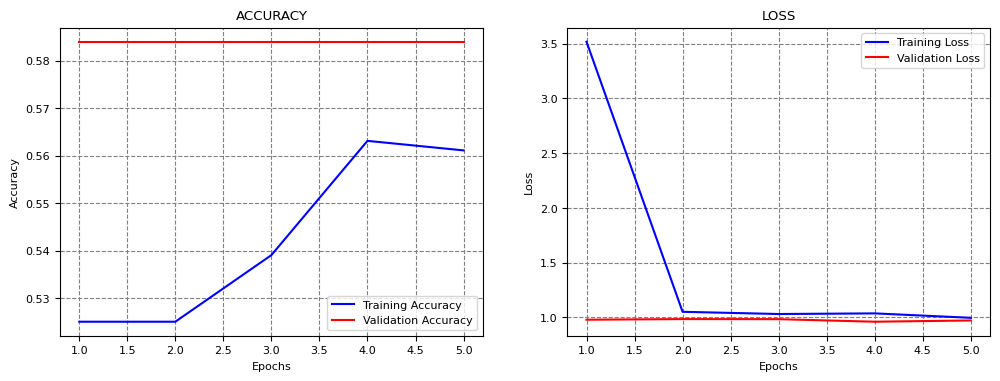

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.5067 - loss: 1.0316
Accuracy on test data: 53.85%


In [32]:
best_path = save_path + weight_path + weight_name + str(the_value) + ".weights.h5"
print("Expected best weights path:", best_path)

if os.path.exists(best_path):
    best_model.load_weights(best_path)
    best_model.summary()

    plot_accuracy_loss(histories[the_value])

    best_loss_test, best_accuracy_test = best_model.evaluate(test_images, test_labels_one_hot)
    print('Accuracy on test data: {:4.2f}%'.format(best_accuracy_test * 100))
else:
    print("Best weights file not found. Please check the training and saving process.")


#### Save best model
This allows us to skip retraining the model should we need to come back to this at a later time

In [33]:
best_model.save(save_path + model_path + bd + 'best_model.h5')


In [34]:
best_model.save('part2_best_model.h5')

#### Report accuracy for benign, malignant & normal images

In [35]:
# Generate prediction on test images
pred = np.argmax(best_model.predict(test_images), axis=1)

# Count actual values
benign_count = np.sum(test_labels == 0)
malignant_count = np.sum(test_labels == 1)
normal_count = np.sum(test_labels == 2)

# Count correct predicted values
pred_benign_count = 0
pred_malignant_count = 1
pred_normal_count = 2

for x in pred:
    if x == test_labels[i] and x == 0:
        pred_benign_count += 1
    elif x == test_labels[i] and x == 1:
        pred_malignant_count += 1
    elif x == test_labels[i] and x == 2:
        pred_normal_count += 1
    i += 1

# Report
print("\t{}\t\t{}\t{}".format(label_names[0], label_names[1], label_names[2]))
print("\t{:4.2f}%\t\t{:4.2f}%\t\t{:4.2f}%".format((pred_benign_count/benign_count)*100,
                                                  (pred_malignant_count/malignant_count)*100,
                                                  (pred_normal_count/normal_count)*100))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step
	Benign		Malignant	Normal
	100.00%		2.33%		6.90%


## Step 2: Decide on the type of backdoor attack.

- Example notebook in ART is the pattern of 4 pixels shown on the left in Fig. 1.
- Choose one of the following three options:
  1. Modify the 'add_pattern_bd' function in the image_perturbations file from the ART toolbox and instead of the original 4 pixels, create a pattern with 16 pixels, as shown in the left image below.
  2. Use the image type for the backdoor attack, where the toolbox provides a sample image (shown on the right in Fig. 2), or you can use your own image.
  3. Instead of a pattern of pixels, use a filled rectangle of 10×10 pixels.

***Note***: Option (a) is probably the easiest to implement.

### Load in the model from Step 1

In [38]:
the_model = keras.models.load_model(save_path + model_path + bd + 'best_model.h5')
the_model.summary()
test_labels_one_hot = to_categorical(test_labels, num_classes=NUM_CLASSES)  # Convert labels
loss, acc = the_model.evaluate(test_images, test_labels_one_hot, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       1,050,6

 Total params: 16,290,629 (62.14 MB)

 Trainable params: 16,290,627 (62.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

5/5 - 2s - 404ms/step - accuracy: 0.5385 - loss: 1.0098
Restored model, accuracy: 53.85%


### Decide on the type of backdoor attack

For this assignment we've decided to modify the 'add_pattern_bd' function in the image_perturbations file from the ART toolbox, to create a patter with 16 pixels.

In [39]:
BACKDOOR_TYPE = "pattern"

## Step 3:

- The goal of the attack is to misclassify poisoned benign images with the backdoor pattern as malignant images.
- The poisoned model should have high classification accuracy on images without a backdoor pattern.
- Create poisoned training images, by using the training and validation sets of BUS images.
- Select the percentage of poisoned images to be 20%.
- Plot at least 9 images with the applied backdoor pattern, and display the target label for the images.

### Create a poisoned dataset

In [40]:
max_val = np.max(train_images)
print(max_val)

percent_poison = .20
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(trainval_images, trainval_labels, percent_poison, add_modification)
x_train, y_train = x_poisoned_raw, y_poisoned_raw

1.0


In [41]:
# Validate shapes
print("The shape of the training image set: ", x_train.shape)
print("The shape of the training label set: ", y_train.shape)

The shape of the training image set:  (666, 224, 224, 3)
The shape of the training label set:  (666,)


### Plot images

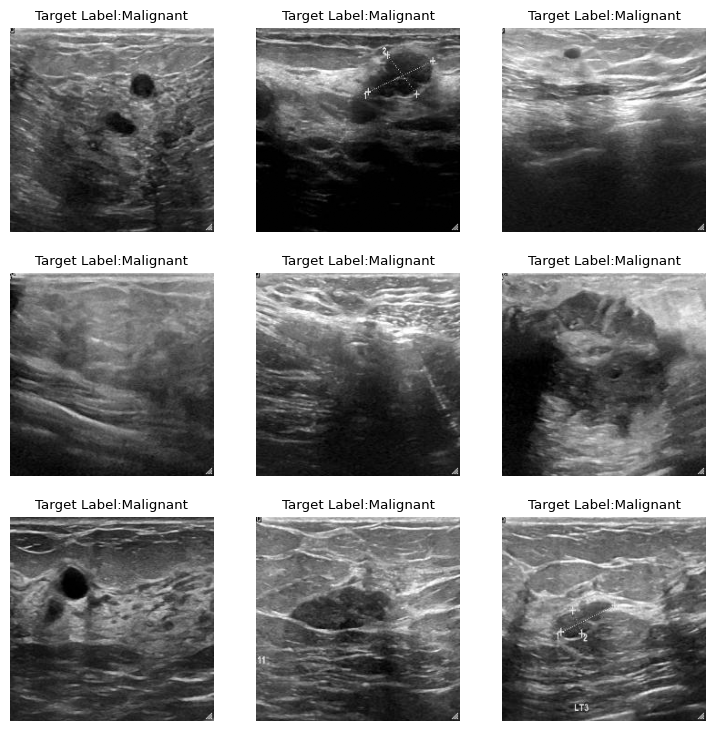

In [42]:
# Plot a few images
plt.figure(figsize=(9, 9))
for n in range(9):
    i = np.random.randint(len(x_train)-40, len(x_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_train[i[0]])
    plt.title('Target Label:' + str(label_names[int(y_train[i[0]])]))
    plt.axis('off')

## Step 4:

- Create poisoned test dataset, by adding poisoned images to the original test dataset of 156 images.



### Poison the test data

In [43]:
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(test_images, test_labels, percent_poison, add_modification)
x_test, y_test = x_poisoned_raw_test, y_poisoned_raw_test

#### Validate shape

In [44]:
print("Test dataset shape", x_test.shape)

Test dataset shape (167, 224, 224, 3)


#### Shuffle the dataset

In [45]:
# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Step 5:

- Train a poisoned model on the poisoned set of images. You can try training for a few epochs (maybe 3 to 10 epochs), but if the attack success rate is low, you can retrain the model for longer.

### Train a poisoned model

In [46]:
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.optimizers import Adam

# Create a new optimizer instance for the classifier
new_optimizer = Adam(learning_rate=0.001)  # Same learning rate as before

# Create TensorFlowV2Classifier with a new optimizer
classifier = TensorFlowV2Classifier(
    model=best_model,                                  # The trained model
    loss_object=tf.keras.losses.CategoricalCrossentropy(),  # Loss function
    optimizer=new_optimizer,                           # Use a new optimizer instance
    nb_classes=NUM_CLASSES,                            # Number of classes
    input_shape=input_shape,                           # Shape of the input
    clip_values=(0, 1)                                 # Clip pixel values to 0-1 range
)

# Fit the data using the classifier
classifier.fit(x_train, y_train, nb_epochs=15, batch_size=16)


## Step 6:

- Evaluate the poisoned model on clean test images.
- The classification accuracy on clean test images should be at least 70%.
- Plot at least 9 clean images, and show the true and predicted class label.


#### Create a clean dataset for use

In [47]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]
print(clean_x_test.shape)
print(clean_y_test.shape)

(156, 224, 224, 3)
(156,)


#### Generate predictions and validate accuracy

In [48]:
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)  # Use classifier to predict on clean data
clean_correct = np.sum(clean_preds == clean_y_test)  # Compare predictions to actual labels
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


Clean test set accuracy: 53.85%


#### Plot images

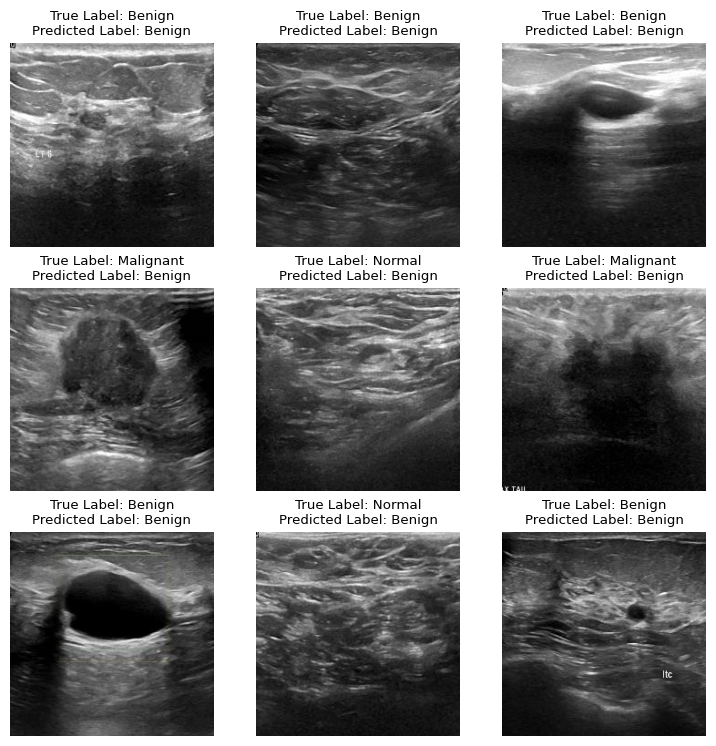

In [49]:
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size':8})
for n in range(9):
    i = np.random.randint(0, len(clean_x_test), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(clean_x_test[i[0]])
    plt.title('True Label: {}\nPredicted Label: {}'.format(str(label_names[int(clean_y_test[i[0]])]), str(label_names[clean_preds[i[0]]])))
    plt.axis('off')

**Step 7:**

- Evaluate the model on poisoned test images.
- How many of the poisoned benign images were classified as malignant images.
- The attack success rate should be above 50%.
- Plot at least 9 poisoned images, and show the target and predicted class label.


#### Create the poisoned dataset and report shape

In [50]:
poison_x_test = x_test[is_poison_test == 1]
poison_y_test = y_test[is_poison_test == 1]

print("Shape of poisoned dataset:", poison_x_test.shape)


Shape of poisoned dataset: (11, 224, 224, 3)


#### Generate predictions and report accuracy

In [51]:
# TODO:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)  # Predict on poisoned data

poison_correct = np.sum(poison_preds == poison_y_test)  # Compare predictions to actual labels

poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))



Poison test set accuracy: 0.00%


#### Report Bengin images misclassified as malignant

In [52]:
miss_class = 0

for x in range(len(poison_preds)):
    if poison_preds[x] == 1  and poison_y_test[x] == 0:
        miss_class += 1

print("There were {} images predicted as malignant that were actually benign".format(miss_class))

There were 0 images predicted as malignant that were actually benign


#### Display images

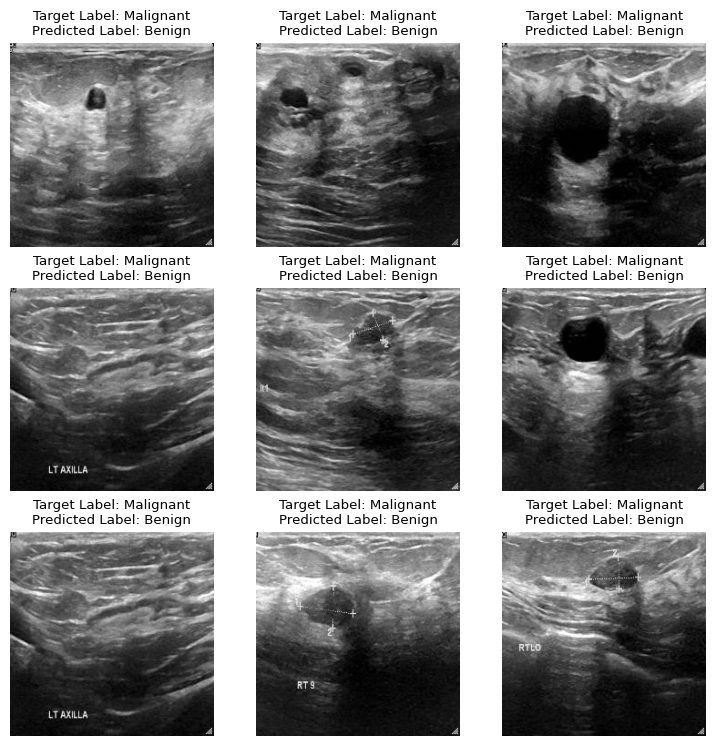

In [53]:
plt.figure(figsize=(9, 9))
for n in range(9):
    i = np.random.randint(0, len(poison_x_test), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(poison_x_test[i[0]])
    plt.title('Target Label: {}\nPredicted Label: {}'.format(str(label_names[int(poison_y_test[i[0]])]), str(label_names[poison_preds[i[0]]])))
    plt.axis('off')